In [2]:
import random

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

from arch import arch_model

from Garch import GARCH

### 1. Generate synthetic data for basic GARCH(1,1)

Mean Model
$$ r_t = e_t $$ 
$$e_t \sim N(0, \sigma_t^2)$$

Volatility Model 
$$ \sigma_t^2 = \omega +  \alpha e_{t-1}^2 + \beta \sigma_{t-i}^2  $$

In [3]:
e = [0]  # errors e_t
sigma2 = [1] # sigma sigma_t
omega, alpha, beta = 0.2, 0.3, 0.5

for t in range(1000):
    sigma2_t = omega + alpha * e[-1]**2 + beta * sigma2[-1]
    e_t = random.gauss(0, sigma2_t**0.5)
    
    e.append(e_t)
    sigma2.append(sigma2_t)

e = e[1:]
sigma2 = sigma2[1:]

In [4]:
# Fit using ARCH library
model = arch_model(100*e, vol='GARCH', mean='zero', p=1, q=1)
garch_fit = model.fit(disp='off')

garch_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -129545.
Distribution:                  Normal   AIC:                           259096.
Method:            Maximum Likelihood   BIC:                           259125.
                                        No. Observations:               100000
Date:                Mon, Feb 10 2025   Df Residuals:                   100000
Time:                        00:41:17   Df Model:                            0
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          0.2671  4.736e-03     56.402      0.000 [  0.258,  0.276]
alpha[1]       0.3537  5.663e-03     62.466      0.000 [  0.343,  0.365]
beta[1]        0.3555  7.589e-03     46.839      0.000 [  0.341,  0.370]
========================================================================

Covariance estimator: robust
"""

### 2. Generate synthetic data for GARCH(1,1) with one exo variable in the volatility model

* Assumption: exo variable is normally distributed with $ X \sim N(0, 1) $

Mean Model
$$ r_t = e_t $$ 
$$e_t \sim N(0, \sigma_t^2)$$

Volatility Model 
$$ \sigma_t^2 = \omega +  \alpha e_{t-1}^2 + \beta \sigma_{t-i}^2 + 
    \gamma x_t^2$$

$$x_t \sim N(0, 1)$$

In [5]:
# Define volatility component coefficients
omega, alpha, beta, gamma = 0.1, 0.1, 0.4, 0.05

T = 1000

In [6]:
e = [0]  # errors e_t
sigma2 = [1] # sigma sigma_t
x = np.random.randn(T, 1)

for t in range(T):
    sigma2_t = omega + alpha * e[-1]**2 + beta * sigma2[-1] + gamma * x[t]**2
    e_t = random.gauss(0, sigma2_t**0.5) 

    e.append(e_t)
    sigma2.append(sigma2_t)

e = e[1:]
sigma2 = sigma2[1:]

In [7]:
# Fit using ARCH library, without exogeneous
model = arch_model(e, vol='GARCH', mean='zero', p=1, q=1)
garch_fit = model.fit(disp='off')

garch_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:               -788.208
Distribution:                  Normal   AIC:                           1582.42
Method:            Maximum Likelihood   BIC:                           1597.14
                                        No. Observations:                 1000
Date:                Mon, Feb 10 2025   Df Residuals:                     1000
Time:                        00:41:17   Df Model:                            0
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.1602  5.712e-02      2.804  5.045e-03  [4.822e-02,  0.272]
alpha[1]       0.1126  3.904e-02      2.884  3.922e-03  [3.609e-02,  0.189]
beta[1]        0.3291      0.208      1.580      0.114 [-7.912e-02,  0.737]
===========================================================================

Covariance estimator: robust
"""

In [8]:
# Fit without exogenous
garch_without_exo = GARCH(p=1, q=1, z=0)
garch_without_exo.train(e)

In [9]:
garch_with_exo = GARCH(p=1, q=1, z=1)
garch_with_exo.train(e, x=x)

In [10]:
garch_with_exo.beta

array([0.44737572])

In [11]:
def mse(arr1, arr2):
    if len(arr1) != len(arr2):
        return False
    return np.sum(np.square(np.array(arr1) - np.array(arr2)))

In [12]:
print(mse(sigma2, garch_without_exo.sigma2))
print(mse(sigma2, garch_with_exo.sigma2))


11913.340053149674
15099.599767181497


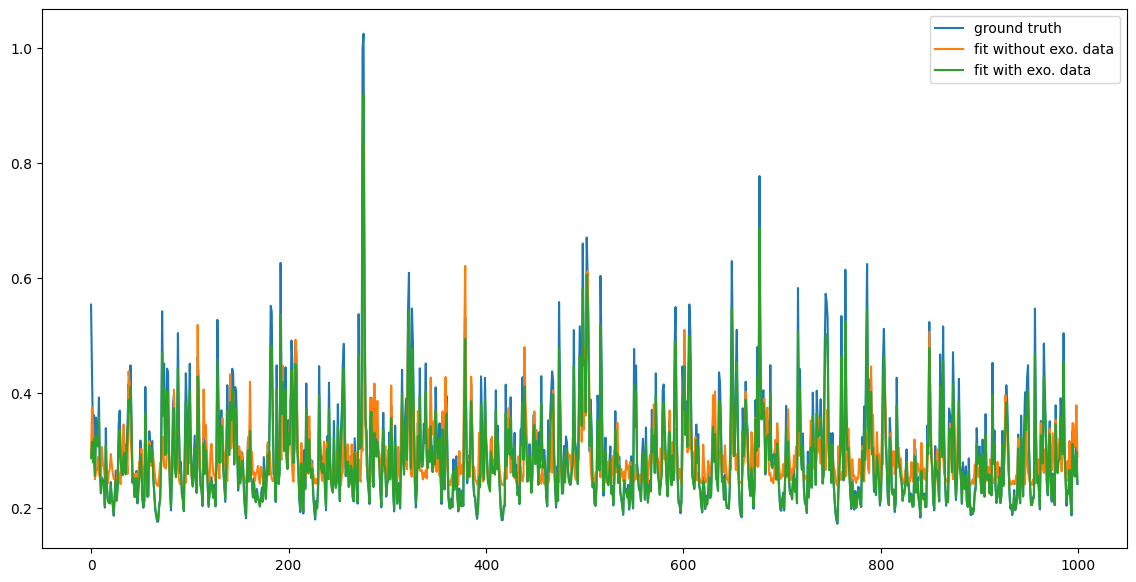

In [13]:

f, axs = plt.subplots(figsize=(14,7))

plt.plot(sigma2, label='ground truth')
plt.plot(garch_without_exo.sigma2, label='fit without exo. data')
plt.plot(garch_with_exo.sigma2, label='fit with exo. data')

plt.legend()

### More rigorous approach: Using a grid of model parameters (see below) to define varying data. For each generated data we fit two models, one without using the exogenous data and another with the exogenous data. We then compare   

In [14]:
import itertools

In [15]:
def generate_data(omega: float, alpha: float, beta: float, gamma: float, T: int = 1000):
    e = np.zeros(T)
    sigma2 = np.zeros(T)
    x = np.random.randn(T, 1)

    sigma2[0] = 1  

    for t in range(1, T):  
        sigma2[t] = omega + alpha * e[t-1]**2 + beta * sigma2[t-1] + gamma * x[t-1]**2
        e[t] = np.random.normal(0, np.sqrt(sigma2[t]))

    return e, sigma2, x

In [ ]:
omegas = [0.1]
alphas = [0.1, 0.4]
betas = [0.1, 0.4]
gammas = [0, 0.1, 0.4]

results = []

for params in itertools.product(omegas, alphas, betas, gammas):

    e, sigma2, x = generate_data(*params)

    param_data = [*params]

    garch_without_exo = GARCH(p=1, q=1, z=0)
    garch_without_exo.train(e)
    model_params = garch_without_exo.omega, garch_without_exo.alpha[0], garch_without_exo.beta[0]
    param_data.extend(model_params)

    garch_with_exo = GARCH(p=1, q=1, z=1)
    garch_with_exo.train(e, x=x)
    model_params = garch_with_exo.omega, garch_with_exo.alpha[0], garch_with_exo.beta[0], garch_with_exo.gammas[0][0]
    param_data.extend(model_params)

    without_exo_MSE = mse(sigma2, garch_without_exo.sigma2)
    with_exo_MSE = mse(sigma2, garch_with_exo.sigma2)
    param_data.extend([without_exo_MSE, with_exo_MSE])

    results.append(param_data)

columns = ['omega', 'alpha', 'beta', 'gamma',
            'omega_wo_exo', 'alpha_wo_exo', 'beta_wo_exo',
            'omega_with_exo', 'alpha_with_exo', 'beta_with_exo', 
            'gamma_with_exo', 'without_exo_MSE', 'with_exo_MSE']
result_df = pd.DataFrame(columns=columns, data=results)


C:\Users\Wei Hao\AppData\Local\Temp\ipykernel_23008\4104399498.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sigma2[t] = omega + alpha * e[t-1]**2 + beta * sigma2[t-1] + gamma * x[t-1]**2


In [18]:
result_df

,omega,alpha,beta,gamma,omega_wo_exo,alpha_wo_exo,beta_wo_exo,omega_with_exo,alpha_with_exo,beta_with_exo,gamma_with_exo,without_exo_MSE,with_exo_MSE
0,0.1,0.1,0.1,0.0,0.060115,0.069034,0.425111,0.060734,0.069872,0.410767,0.001010,0.850953,0.851011
1,0.1,0.1,0.1,0.1,0.240615,0.177396,0.000002,0.032689,0.036000,0.640756,0.056651,29.752821,24.561271
2,0.1,0.1,0.1,0.4,0.626758,0.101287,0.000011,0.048452,0.016102,0.601432,0.233402,325.637593,284.984435
3,0.1,0.1,0.4,0.0,0.035745,0.119297,0.718996,0.029391,0.114549,0.734211,0.004327,2.664934,2.777533
4,0.1,0.1,0.4,0.1,0.234409,0.110701,0.265145,0.060127,0.065154,0.672560,0.039831,23.059488,16.365343
5,0.1,0.1,0.4,0.4,0.414029,0.120824,0.424739,0.064527,0.046369,0.718954,0.149170,369.749171,245.634956
6,0.1,0.4,0.1,0.0,0.090968,0.308092,0.206223,0.080596,0.307659,0.222610,0.007809,1.491740,1.601078
7,0.1,0.4,0.1,0.1,0.165407,0.366075,0.064542,0.040547,0.246871,0.461125,0.045289,23.159489,25.645883
8,0.1,0.4,0.1,0.4,0.434722,0.516096,0.089266,0.041392,0.280495,0.414280,0.290890,379.441858,405.975398
9,0.1,0.4,0.4,0.0,0.095923,0.414584,0.431059,0.085292,0.423097,0.417035,0.015110,9.137705,9.438881
